<a href="https://colab.research.google.com/github/carbaluar/Presentaci-n/blob/main/Prueba_LB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Generamos el Archivo de Excel para la lectura

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import sqlite3
import datetime

In [2]:

dfAL = pd.read_excel('/content/DBdiario_2.xlsx',sheet_name='diario B')
dfAL.head()

,dia,dens B,coque,restos,pot B,RdensB
0,2018-01-01,1.430199,0.86,0.29,7.7,1
1,2018-01-02,1.428183,0.86,0.27,7.8,1
2,2018-01-05,1.432999,0.86,0.38,7.8,1
3,2018-01-06,1.431003,0.86,0.31,7.7,1
4,2018-01-07,1.436301,0.86,0.32,7.7,1


In [3]:
dfAL.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 758 entries, 0 to 757
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   dia     758 non-null    datetime64[ns]
 1   dens B  758 non-null    float64       
 2   coque   758 non-null    float64       
 3   restos  758 non-null    float64       
 4   pot B   758 non-null    float64       
 5   RdensB  758 non-null    int64         
dtypes: datetime64[ns](1), float64(4), int64(1)
memory usage: 35.7 KB


In [4]:
from sklearn.model_selection import train_test_split

In [5]:
# divido entre train y test/validación en 70%/30%
dfAL_train, dfAL_test_validation = train_test_split(dfAL, train_size=0.7, stratify = dfAL["RdensB"])

In [6]:
# divido entre train y test/validación en 15% y 15%
dfAL_test, dfAL_validation = train_test_split(dfAL_test_validation, train_size=0.5, stratify = dfAL_test_validation["RdensB"])

In [7]:
dfAL_train.shape

(530, 6)

In [8]:
dfAL_test.shape

(114, 6)

In [9]:
dfAL_validation.shape

(114, 6)

### Modelo Gaussiano

In [10]:
from sklearn.naive_bayes import GaussianNB

In [11]:
clf = GaussianNB(priors=None, var_smoothing= 0.001)

In [12]:
dfAL_train2 = dfAL_train[["pot B","coque","restos","RdensB"]].copy()

In [13]:
clf.fit(dfAL_train2.drop("RdensB",axis=1), dfAL_train2["RdensB"])

GaussianNB(priors=None, var_smoothing=0.001)

In [14]:
clf.score(dfAL_train2.drop("RdensB",axis=1), dfAL_train2["RdensB"])

0.8867924528301887

In [15]:
dfAL_validation2 = dfAL_validation[["pot B","coque","restos","RdensB"]].copy()
dfAL_test_validation2 = dfAL_test_validation[["pot B","coque","restos","RdensB"]].copy()

In [16]:
clf.score(dfAL_validation2.drop("RdensB",axis=1), dfAL_validation2["RdensB"])


0.8947368421052632

In [17]:
clf.score(dfAL_test_validation2.drop("RdensB",axis=1), dfAL_test_validation2["RdensB"])

0.8859649122807017

In [18]:
BuscaSmoot = [0.1, 0.001, 0.0001, 0.00001, 0.000001, 0.000000000001]

In [19]:
scores = list()
for busca in BuscaSmoot:
    clf = GaussianNB(var_smoothing = busca)
    clf.fit(dfAL_train2.drop("RdensB",axis=1), dfAL_train2["RdensB"])
    scores.append(clf.score(dfAL_validation2.drop("RdensB",axis=1), dfAL_validation2["RdensB"]))

print("Máximo score con un smoothing de: ", BuscaSmoot[scores.index(max(scores))], "--> valor de Score: ", max(scores))

Máximo score con un smoothing de:  0.001 --> valor de Score:  0.8947368421052632


In [20]:
scores = list()
for busca in BuscaSmoot:
    clf = GaussianNB(var_smoothing = busca)
    clf.fit(dfAL_train2.drop("RdensB",axis=1), dfAL_train2["RdensB"])
    scores.append(clf.score(dfAL_test_validation2.drop("RdensB",axis=1), dfAL_test_validation2["RdensB"]))

print("Máximo score con un smoothing de: ", BuscaSmoot[scores.index(max(scores))], "--> valor de Score: ", max(scores))

Máximo score con un smoothing de:  0.0001 --> valor de Score:  0.8903508771929824


Dato Obtenido

In [21]:
from sklearn.metrics import confusion_matrix, roc_auc_score
import numpy as np
dfAL_train2.head()

,pot B,coque,restos,RdensB
513,7.2,0.85,0.26,1
453,8.3,0.82,0.21,1
438,7.6,0.81,0.22,0
603,7.7,0.82,0.22,1
313,7.8,0.83,0.25,1


In [22]:
clf.predict(np.array([[8,0.85,0.3]]))

array([1])

Matriz

In [23]:
y_true = 1*np.array(dfAL_validation2["RdensB"])

In [24]:
y_true2 = 1*np.array(dfAL_test_validation2["RdensB"])

In [25]:
y_pred = clf.predict_proba(dfAL_validation2.drop("RdensB",axis=1))

In [26]:
y_pred2 = clf.predict_proba(dfAL_test_validation2.drop("RdensB",axis=1))

In [27]:
print("Matriz de Confusión Alfa 0.25")
print(confusion_matrix(y_true,y_pred[:,1]>0.25))

Matriz de Confusión Alfa 0.25
[[  1  12]
 [  1 100]]


In [28]:
print("Matriz de Confusión Alfa 0.25")
print(confusion_matrix(y_true2,y_pred2[:,1]>0.25))

Matriz de Confusión Alfa 0.25
[[  3  23]
 [  2 200]]


In [29]:
alfa = 0.02
recalls = np.zeros(100)
precisions= np.zeros(100)
FPR = np.zeros(100)
alfas = np.linspace(0,1,100)
for idx,alfa in enumerate(alfas):
    tn, fp, fn, tp = confusion_matrix(y_true,y_pred[:,1]>alfa).ravel()
    recalls[idx] = (tp/(tp+fn))
    precisions[idx] = (tp/(tp+fp))
    FPR[idx]= (fp/(fp+tn))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in long_scalars
  if __name__ == '__main__':


In [56]:
alfa = 0.02
recalls = np.zeros(100)
precisions= np.zeros(100)
FPR = np.zeros(100)
alfas = np.linspace(0,1,100)
for idx,alfa in enumerate(alfas):
    tn, fp, fn, tp = confusion_matrix(y_true2,y_pred2[:,1]>alfa).ravel()
    recalls[idx] = (tp/(tp+fn))
    precisions[idx] = (tp/(tp+fp))
    FPR[idx]= (fp/(fp+tn))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in long_scalars
  if __name__ == '__main__':


In [57]:
print("Para un alfa 0.25 --> Valor de recall", recalls[25], "Valor de Precisions", precisions[25], "Valor de FPR", FPR[25])
print("Para un alfa 0.5 --> Valor de recall", recalls[50], "Valor de Precisions", precisions[50], "Valor de FPR", FPR[50])
print("Para un alfa 0.75 --> Valor de recall", recalls[75], "Valor de Precisions", precisions[75], "Valor de FPR", FPR[75])

Para un alfa 0.25 --> Valor de recall 0.9900990099009901 Valor de Precisions 0.8968609865470852 Valor de FPR 0.8846153846153846
Para un alfa 0.5 --> Valor de recall 0.9801980198019802 Valor de Precisions 0.9041095890410958 Valor de FPR 0.8076923076923077
Para un alfa 0.75 --> Valor de recall 0.9356435643564357 Valor de Precisions 0.9310344827586207 Valor de FPR 0.5384615384615384


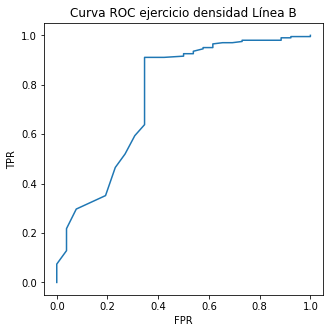

In [32]:
plt.figure(figsize=[5,5])
plt.plot(FPR,recalls)
plt.title("Curva ROC ejercicio densidad Línea B")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.show()

Modelo LDA

In [33]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [34]:
LDA_clf = LinearDiscriminantAnalysis()

In [35]:
LDA_clf.fit(dfAL_train2.drop("RdensB",axis=1), dfAL_train2["RdensB"])

LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
                           solver='svd', store_covariance=False, tol=0.0001)

In [36]:
LDA_clf.score(dfAL_train2.drop("RdensB",axis=1), dfAL_train2["RdensB"])

0.8886792452830189

In [37]:
LDA_clf.score(dfAL_validation2.drop("RdensB",axis=1), dfAL_validation2["RdensB"])

0.8859649122807017

In [38]:
LDA_clf.predict(np.array([[7,0.86,0.25]]))

array([1])

In [39]:
y_true2 = 1*np.array(dfAL_test_validation2["RdensB"])

In [40]:
y_pred_LDA = LDA_clf.predict_proba(dfAL_test_validation2.drop("RdensB",axis=1))

In [41]:
print("Matriz de Confusión Alfa 0.25")
print(confusion_matrix(y_true2,y_pred_LDA[:,1]>0.25))

Matriz de Confusión Alfa 0.25
[[  0  26]
 [  1 201]]


Modelo QDA

In [42]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
QDA_clf = QuadraticDiscriminantAnalysis()

In [43]:
QDA_clf.fit(dfAL_train2.drop("RdensB",axis=1), dfAL_train2["RdensB"])

QuadraticDiscriminantAnalysis(priors=None, reg_param=0.0,
                              store_covariance=False, tol=0.0001)

In [44]:
QDA_clf.score(dfAL_train2.drop("RdensB",axis=1), dfAL_train2["RdensB"])

0.8830188679245283

In [45]:
QDA_clf.score(dfAL_validation2.drop("RdensB",axis=1), dfAL_validation2["RdensB"])

0.8859649122807017

In [46]:
QDA_clf.predict(np.array([[5,0.86,0.25]]))

array([0])

Modelo de Regresión Log.

In [47]:
from sklearn.linear_model import LogisticRegression
LR_clf=LogisticRegression(C=1e9, verbose=1)

In [48]:
LR_clf.fit(dfAL_train2.drop("RdensB",axis=1), dfAL_train2["RdensB"])

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


LogisticRegression(C=1000000000.0, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=1,
                   warm_start=False)

In [49]:
LR_clf.score(dfAL_train2.drop("RdensB",axis=1), dfAL_train2["RdensB"])

0.8886792452830189

In [50]:
LR_clf.score(dfAL_validation2.drop("RdensB",axis=1), dfAL_validation2["RdensB"])

0.8859649122807017

Modelo de Redes Neuronales

In [51]:
dfAL_train2.shape

(530, 4)

In [52]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization
from tensorflow.keras.optimizers import Adam, SGD

In [53]:
RN_clf= Sequential()
RN_clf.add(BatchNormalization(input_shape=(3,)))
RN_clf.add(Dense(16, input_dim=5, activation='relu'))
RN_clf.add(Dense(1, activation='sigmoid'))

In [54]:
RN_clf.compile(loss='mean_squared_error',
              optimizer='SGD',
              metrics=['binary_accuracy'])

In [55]:
RN_clf.fit(dfAL_train2.drop("RdensB",axis=1), dfAL_train2["RdensB"], epochs=300)

Epoch 1/300
17/17 [==============================] - 1s 2ms/step - loss: 0.2555 - binary_accuracy: 0.4733
Epoch 2/300
17/17 [==============================] - 0s 1ms/step - loss: 0.2445 - binary_accuracy: 0.5312
Epoch 3/300
17/17 [==============================] - 0s 1ms/step - loss: 0.2306 - binary_accuracy: 0.5933
Epoch 4/300
17/17 [==============================] - 0s 1ms/step - loss: 0.2175 - binary_accuracy: 0.6424
Epoch 5/300
17/17 [==============================] - 0s 1ms/step - loss: 0.2055 - binary_accuracy: 0.6606
Epoch 6/300
17/17 [==============================] - 0s 2ms/step - loss: 0.1988 - binary_accuracy: 0.7273
Epoch 7/300
17/17 [==============================] - 0s 1ms/step - loss: 0.1831 - binary_accuracy: 0.7746
Epoch 8/300
17/17 [==============================] - 0s 1ms/step - loss: 0.1787 - binary_accuracy: 0.8173
Epoch 9/300
17/17 [==============================] - 0s 1ms/step - loss: 0.1733 - binary_accuracy: 0.8304
Epoch 10/300
17/17 [==========================